# Multiview Independent Component Analysis (ICA) Tutorial

Adopted from the code at [https://github.com/hugorichard/multiviewica](https://github.com/hugorichard/multiviewica) and their tutorial written by:

Authors: Hugo Richard, Pierre Ablin

License: BSD 3 clause

Three multiview ICA algorithms are compared. GroupICA concatenates the individual views prior to dimensionality reduction and running ICA over the result. PermICA is more sensitive to individual discrepencies, and computes ICA on each view before aligning the reuslts using the hungarian algorithm. Lastly, MultiviewICA performs the best by optimizing the set of mixing matrices relative to the average source signal.

In [108]:
import numpy as np
import matplotlib.pyplot as plt

from mvlearn.decomposition.mv_ica import MultiviewICA, PermICA, GroupICA

In [94]:
# sigmas: data noise
# m: number of subjects
# k: number of components
# n: number of samples
sigmas = np.logspace(-2, 1, 6)
n_seeds = 3
m, k, n = 5, 3, 1000

cm = plt.cm.tab20
algos = [
    ("MultiViewICA", cm(0), MultiviewICA),
    ("PermICA", cm(2), PermICA),
    ("GroupICA", cm(6), GroupICA),
]


def amari_d(W, A):
    P = np.dot(A, W)

    def s(r):
        return np.sum(np.sum(r ** 2, axis=1) / np.max(r ** 2, axis=1) - 1)

    return (s(np.abs(P.T)) + s(np.abs(P))) / (2 * P.shape[1])


plots = []
for name, color, algo in algos:
    means = []
    lows = []
    highs = []
    for sigma in sigmas:
        dists = []
        for seed in range(n_seeds):
            rng = np.random.RandomState(seed)
            S_true = rng.laplace(size=(n, k))
            A_list = rng.randn(m, k, k)
            noises = rng.randn(m, n, k)
            Xs = np.array([S_true.dot(A) for A in A_list])
            Xs += [sigma * N.dot(A) for A, N in zip(A_list, noises)]
            ica = algo(tol=1e-4, max_iter=1000, random_state=0).fit(Xs)
            W = ica.unmixings_
            dist = np.mean([amari_d(W[i], A_list[i]) for i in range(m)])
            dists.append(dist)
        dists = np.array(dists)
        mean = np.mean(dists)
        low = np.quantile(dists, 0.1)
        high = np.quantile(dists, 0.9)
        means.append(mean)
        lows.append(low)
        highs.append(high)
    lows = np.array(lows)
    highs = np.array(highs)
    means = np.array(means)
    plots.append((highs, lows, means))

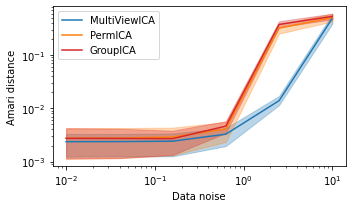

In [95]:
fig = plt.figure(figsize=(5, 3))
for i, (name, color, algo) in enumerate(algos):
    highs, lows, means = plots[i]
    plt.fill_between(
        sigmas, lows, highs, color=color, alpha=0.3,
    )
    plt.loglog(
        sigmas, means, label=name, color=color,
    )
plt.legend()
x_ = plt.xlabel(r"Data noise")
y_ = plt.ylabel(r"Amari distance")
fig.tight_layout()
plt.show()

MultiviewICA has the best performance (lowest Amari distance).